In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import integrate, signal
from scipy.optimize import fsolve
from scipy.optimize import root_scalar
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from toy_models import *
import warnings
warnings.filterwarnings('ignore')

%matplotlib widget

Trajectory using the simplify toy model:

$U = -J_{12}\cos(\theta_1-\theta_2) - J_{1}\cos(\theta_1-\omega_1) - J_{2}\cos(\theta_2-\omega_2)$

with:

$\begin{equation}
    J_i = \begin{cases}
        J_{max}\hspace{.5cm} \text{if } J_i \in N_{\theta_0}(\omega_i) \\
        1 \hspace{1cm} \text{otherwise}
        \end{cases}
\end{equation}
$

In [2]:
def dU_comp(theta1, theta2, k, omega1, omega2):
    '''
    Equation of motion
    dU/dtheta1 and dU/dtheta2
    '''
    return np.array([k*np.sin(theta1-theta2) + np.sin(theta1 - omega1), -k*np.sin(theta1-theta2) + np.sin(theta2 - omega2)])

def is_sol_comp(theta1, theta2, k, omega1, omega2):
    '''
    Check if the given theta1 and theta2 are solutions of dU=0.
    Return True if they are solutions, False otherwise.
    '''
    delta = abs(dU_comp(theta1, theta2, k, omega1, omega2)) < 1e-3
    return delta[0] and delta[1]

# calculate theta1 and theta2 for different values of K, omega_diff in the decision case
def calculate_thetas_decision(omega1, omega2, theta0):
    '''
    Calculate theta1 and theta2 that satisfy dU=0 and the constraint of theta0. Decision solution.
    '''

    # remove solutions that are not solutions of dU=0 and are not in the range of N(theta0).
    if abs(omega1-omega2)>theta0:
        return [omega1, omega2], [omega1, omega2]
    else:
        return [np.nan, np.nan], [np.nan, np.nan]

# calculate theta1 and theta2 for different values of K, omega_diff in the decision case
def calculate_thetas_decision_om1(omega1, omega2, theta0):
    '''
    Calculate theta1 and theta2 that satisfy dU=0 and the constraint of theta0. Decision solution.
    '''

    # remove solutions that are not solutions of dU=0 and are not in the range of N(theta0).
    if abs(omega1-omega2)>theta0:
        return [omega1], [omega1]
    else:
        return [np.nan], [np.nan]

# calculate theta1 and theta2 for different values of K, omega_diff in the decision case
def calculate_thetas_decision_om2(omega1, omega2, theta0):
    '''
    Calculate theta1 and theta2 that satisfy dU=0 and the constraint of theta0. Decision solution.
    '''

    # remove solutions that are not solutions of dU=0 and are not in the range of N(theta0).
    if abs(omega1-omega2)>theta0:
        return [omega2], [omega2]
    else:
        return [np.nan], [np.nan]

# calculate theta1 and theta2 for different values of K, omega_diff in the compromise case
def calculate_thetas_compromise(K, omega1, omega2, theta0):
    '''
    Calculate theta1 and theta2 that satisfy dU=0 and the constraint of theta0. Compromise solution.
    K = J12/Jmax.
    '''
    omega_diff = omega1 - omega2
    A = np.sin(omega_diff)
    coeff = [4*K**2, -4*K*A, -4*K**2+1, 2*K*A, K**2*A**2]
    roots = np.roots(coeff)
    real_valued = roots.real[abs(roots.imag)<1e-7]
    real_valued = np.unique(real_valued)
    theta1 = np.round(omega1 + np.arcsin(real_valued), 5)
    theta2 = np.round(omega2 - np.arcsin(real_valued), 5)

    # remove solutions that are not solutions of dU=0 and are not in the range of N(theta0).
    for (t1, t2) in zip(theta1, theta2):
        if not is_sol_comp(t1, t2, K, omega1, omega2):
            theta1[theta1==t1] = np.nan
            theta2[theta2==t2] = np.nan
        if (abs(t1-omega1)>theta0):
            theta1[theta1==t1] = np.nan
        if (abs(t2-omega2)>theta0):
            theta2[theta2==t2] = np.nan
    # return the first solution of theta1 and theta2 that is simultaneously not nan
    for (t1, t2) in zip(theta1, theta2):
        if not np.isnan(t1) and not np.isnan(t2):
            return [t1, t2]
    return [np.nan, np.nan]

def Jacobian_comp(theta1, theta2, k, omega1, omega2):
    '''
    Jacobian matrix of compromise solution.
    '''
    return np.array([[k*np.cos(theta1-theta2) + np.cos(theta1 - omega1), -k*np.cos(theta1-theta2)], [-k*np.cos(theta1-theta2), k*np.cos(theta1-theta2) + np.cos(theta2 - omega2)]])

def is_stable_comp(theta1, theta2, k, omega1, omega2):
    '''
    Check if the given theta1 and theta2 are stable.
    Return True if they are stable, False otherwise.
    '''
    if np.isnan(theta1) or np.isnan(theta2):
        return False
    else:
        J = Jacobian_comp(theta1, theta2, k, omega1, omega2)
        # check first element of J is positive and the determinant of J is positive
        return (J[0,0]>0) and (np.linalg.det(J)>0)

def Jacobian_dec(theta1, theta2, k, omega1, omega2):
    '''
    Jacobian matrix of decision solution.
    '''
    return np.array([[k*np.cos(theta1-theta2) + np.cos(theta1 - omega1), -k*np.cos(theta1-theta2)], [-k*np.cos(theta1-theta2), k*np.cos(theta1-theta2)]])

def is_stable_dec(theta1, theta2, k, omega1, omega2):
    '''
    Check if the given theta1 and theta2 are stable.
    Return True if they are stable, False otherwise.
    '''
    if np.isnan(theta1) or np.isnan(theta2):
        return False
    else:
        J = Jacobian_dec(theta1, theta2, k, omega1, omega2)
        # check first element of J is positive and the determinant of J is positive
        return (J[0,0]>0) and (np.linalg.det(J)>0)

In [3]:
class targets:
    """A class representing the targets of the system."""
    x1 : float = 0.0
    y1 : float = 0.0
    x2 : float = 0.0
    y2 : float = 0.0

    def __init__(self, x1=10, y1=1, x2=10, y2=-1):
        """Setup targets."""
        self.x1 = x1
        self.y1 = y1
        self.x2 = x2
        self.y2 = y2

############################################################################################################

class state:
    """A class representing the state of the system."""
    tar : targets
    theta0 : float
    K : float

    x : list = []
    y : list = []

    theta1 : list = []
    theta2 : list = []
    omega1 : list = []
    omega2 : list = []
    reached : bool = False
    preference : str = 'compromise'
    
    def __init__(self, tar=targets(), theta0=np.radians(20), K=5, x=[0], y=[0], theta1=[], theta2=[], omega1=[0.0], omega2=[0.0], reached=False, preference='compromise'):
        """Setup state."""
        self.tar = tar
        self.theta0 = theta0
        self.K = K
        self.x = x
        self.y = y
        self.theta1 = theta1
        self.theta2 = theta2
        self.omega1 = omega1
        self.omega2 = omega2
        self.reached = reached
        self.preference = preference
    
    def __str__(self):
        """Print the state of the system with the targets position."""
        return f'x={self.x}, y={self.y}, theta1={self.theta1}, theta2={self.theta2}, omega1={self.omega1}, omega2={self.omega2}'

    def update_omegas(self):
        """Calculate the angle between the two targets and the current position."""
        self.omega1.clear()
        self.omega2.clear()
        for i in range(len(self.x)):
            self.omega1.append(np.arctan2(self.tar.y1 - self.y[i], self.tar.x1 - self.x[i]))
            self.omega2.append(np.arctan2(self.tar.y2 - self.y[i], self.tar.x2 - self.x[i]))

    def update_position(self, dt):
        """Update the position of the system."""
        # print(len(self.theta1))
        last_x = self.x
        last_y = self.y
        self.x = []
        self.y = []
        for index, (t1, t2) in enumerate(zip(self.theta1, self.theta2)):
            # convert t1 and t2 to list if they are not
            if not isinstance(t1, list):
                t1 = [t1]
            if not isinstance(t2, list):
                t2 = [t2]

            #for j in range(len(last_x)):
            for i in range(len(t1)):
                # self.x.append(last_x[index] + np.cos(t1[i]+t2[i]) * dt)
                # self.y.append(last_y[index] + np.sin(t1[i]+t2[i]) * dt)
                self.x.append(last_x[index] + (np.cos(t1[i])+np.cos(t2[i])) * dt)
                self.y.append(last_y[index] + (np.sin(t1[i])+np.sin(t2[i])) * dt)

        # change reached to True if the system reached the targets
        for i in range(len(self.x)):
            if (abs(self.x[i]-self.tar.x1)<abs(self.tar.x1)*1e-2 and abs(self.y[i]-self.tar.y1)<abs(self.tar.x1)*1e-2) or (abs(self.x[i]-self.tar.x2)<abs(self.tar.x1)*1e-2 and abs(self.y[i]-self.tar.y2)<abs(self.tar.x1)*1e-2):
                self.reached = True

    def calculate_thetas_om1(self):
        """Calculate theta1 and theta2 from the equation of motion with preference for omega1 in case of decision solution."""
        self.theta1.clear()
        self.theta2.clear()
        
        for i in range(len(self.omega1)):
            if abs(self.omega1[i]-self.omega2[i])>self.theta0:
                # decision solution if the targets are close enough (delta > theta0)
                t1, t2 = calculate_thetas_decision_om1(self.omega1[i], self.omega2[i], self.theta0)
                #print(t1, t2)
                self.theta1.append(t1)
                self.theta2.append(t2)
            else:
                # compromise solution if the targets are far enough (delta < theta0)
                t1, t2 = calculate_thetas_compromise(self.K, self.omega1[i], self.omega2[i], self.theta0)
                self.theta1.append(t1)
                self.theta2.append(t2)

    def calculate_thetas_om2(self):
        """Calculate theta1 and theta2 from the equation of motion with preference for omega2 in case of decision solution."""
        self.theta1.clear()
        self.theta2.clear()
        
        for i in range(len(self.omega1)):
            if abs(self.omega1[i]-self.omega2[i])>self.theta0:
                # decision solution if the targets are close enough (delta > theta0)
                t1, t2 = calculate_thetas_decision_om2(self.omega1[i], self.omega2[i], self.theta0)
                #print(t1, t2)
                self.theta1.append(t1)
                self.theta2.append(t2)
            else:
                # compromise solution if the targets are far enough (delta < theta0)
                t1, t2 = calculate_thetas_compromise(self.K, self.omega1[i], self.omega2[i], self.theta0)
                self.theta1.append(t1)
                self.theta2.append(t2)

    def calculate_thetas(self):
        """Calculate theta1 and theta2 from the equation of motion.
        The compromise switch to the decision solution when the former solution become unstable or does not exist."""
        self.theta1.clear()
        self.theta2.clear()

        for i in range(len(self.omega1)):
            # calculate thetas in both cases and choose the one that is stable
            t1_c, t2_c = calculate_thetas_compromise(self.K, self.omega1[i], self.omega2[i], self.theta0)
            if is_stable_comp(t1_c, t2_c, self.K, self.omega1[i], self.omega2[i]):
                self.theta1.append(t1_c)
                self.theta2.append(t2_c)
            else:
                if self.preference == 'om1':
                    t1, t2 = calculate_thetas_decision_om1(self.omega1[i], self.omega2[i], self.theta0)
                elif self.preference == 'om2':
                    t1, t2 = calculate_thetas_decision_om2(self.omega1[i], self.omega2[i], self.theta0)
                else:
                    t1, t2 = calculate_thetas_decision(self.omega1[i], self.omega2[i], self.theta0)
                # print('i m in decision: ', t1, t2)               
                if is_stable_dec(t1[0], t2[0], self.K, self.omega1[i], self.omega2[i]):
                    self.theta1.append(t1)
                    self.theta2.append(t2)
                else:
                    print('Error: No stable solution found!')

In [4]:
# evolve the system and plot the x y position every dt
def evolve(s, dt, t_end):
    """Evolve the system and plot the x y position every dt."""
    x_traj, y_traj = [], []
    theta1, theta2 = [], []
    t = 0
    while t<t_end:
        theta1.append(s.theta1)
        theta2.append(s.theta2)
        s.update_omegas()
        s.calculate_thetas()
        s.update_position(dt)

        x_traj.append(s.x)
        y_traj.append(s.y)
        t += dt
        # interrupt the evolution if the system reached the targets
        if s.reached:
            break
    return x_traj, y_traj, theta1, theta2


## Plot trajectories for different $\theta_0$

In [17]:
sus_theta1 = []
sus_theta2 = []

15
20
25
30
35
40
45


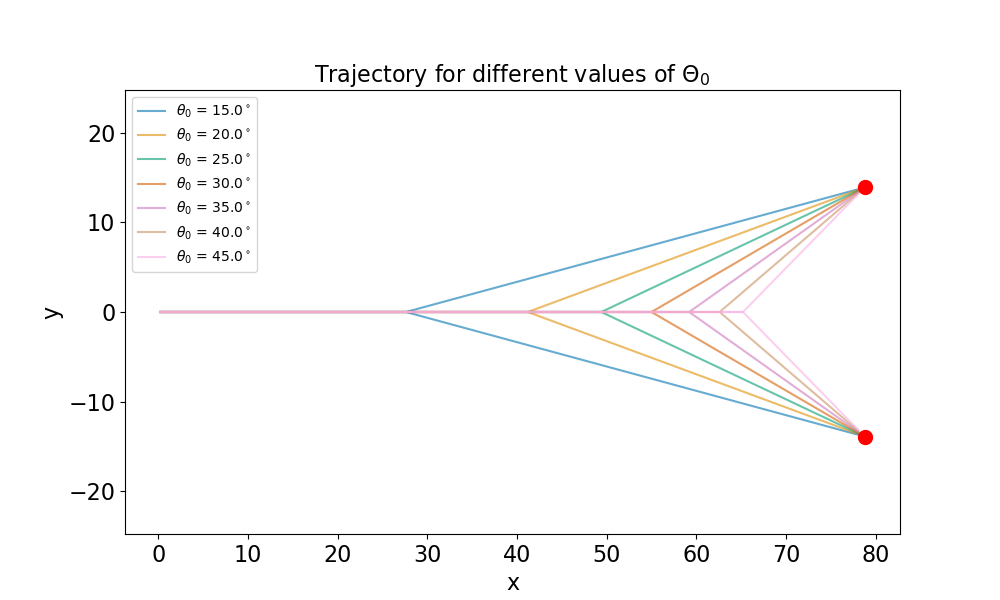

In [26]:
bif_point = []
colors = sns.color_palette("colorblind", 8)

fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111)
for i, theta0 in enumerate([15,20,25,30,35,40,45]):
    print(theta0)
    theta0 = np.radians(theta0)
    t1_x1 = state(tar=targets(x1=80*np.cos(np.radians(10)), y1=80*np.sin(np.radians(10)), x2=80*np.cos(np.radians(10)), y2=-80*np.sin(np.radians(10))), theta0=theta0, K=50, x=[0], y=[0], theta1=[], theta2=[], omega1=[0.0], omega2=[0.0], reached=False, preference='om1')
    # t1_x2 = state(tar=targets(x1=80*np.cos(np.radians(10)), y1=80*np.sin(np.radians(10)), x2=80*np.cos(np.radians(10)), y2=-80*np.sin(np.radians(10))), theta0=theta0, K=30, x=[0], y=[0], theta1=[], theta2=[], omega1=[0.0], omega2=[0.0], reached=False, preference='om2')
    t1_x1_traj, t1_y1_traj, t1_theta1_1, t1_theta2_1 = evolve(t1_x1, 0.1, 80)

    # t1_x2_traj, t1_y2_traj, t1_theta1_2, t1_theta2_2 = evolve(t1_x2, 1, 80)
    t1_x1_traj = [x[0] for x in t1_x1_traj]
    t1_y1_traj = [y[0] for y in t1_y1_traj]

    # set line width
    plt.rc('lines', linewidth=1.5)
    
    plt.plot(t1_x1_traj, t1_y1_traj, color=colors[i], alpha=0.6, label=r'$\theta_0$ = '+str(np.round(np.degrees(theta0), 1))+r'$^\circ$')
    plt.plot(t1_x1_traj, [-x for x in t1_y1_traj], color=colors[i], alpha=0.6)

    # store the bifurcation point
    for i in range(len(t1_y1_traj)):
        if t1_y1_traj[i] != 0:
            bif_point.append([theta0, t1_x1_traj[i]])
            break
    # plt.plot(t1_x2_traj, t1_y2_traj, color=colors[i], alpha=0.6)

# add a legend
plt.legend(loc='upper left')    

# plot the targets
plt.plot(t1_x1.tar.x1, t1_x1.tar.y1, 'ro', markersize=10)
plt.plot(t1_x1.tar.x1, -t1_x1.tar.y1, 'ro', markersize=10)
# plt.plot(t1_x1.tar.x2, t1_x1.tar.y2, 'ro', markersize=10)

#set the axis labels
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)

# set tick size
plt.tick_params(labelsize=16)


# set the title
plt.title(r'Trajectory for different values of $\Theta_0$', fontsize=16)

#add some space between the title and the plot
plt.subplots_adjust(top=0.85)

# save the figure as pdf 300 dpi
#plt.savefig('img/trajectory_theta0.pdf', dpi=300)

# set same scale for both axis
plt.axis('equal');

In [27]:
bif_point

# bifurcation
tar_x = 80*np.cos(np.radians(20))
tar_y = 80*np.sin(np.radians(20))
print(tar_x, tar_y)

# convert bifurcatin x to angle
bif_angle = []
for i in range(len(bif_point)):
    print(bif_point[i][1])
    bif_angle.append([bif_point[i][0], np.degrees(np.arctan(tar_y/(tar_x-bif_point[i][1])))])
bif_angle

75.17540966287268 27.361611466053496
27.792955868937813
41.38747403287254
49.58063110009506
55.17246055942543
59.36282912802572
62.75140019901264
65.33941118663785


[[0.2617993877991494, 30.004841792319013],
 [0.3490658503988659, 39.00069711393383],
 [0.4363323129985824, 46.91090312747594],
 [0.5235987755982988, 53.83099755929942],
 [0.6108652381980153, 59.975903483212534],
 [0.6981317007977318, 65.57876062180205],
 [0.7853981633974483, 70.22741753296903]]

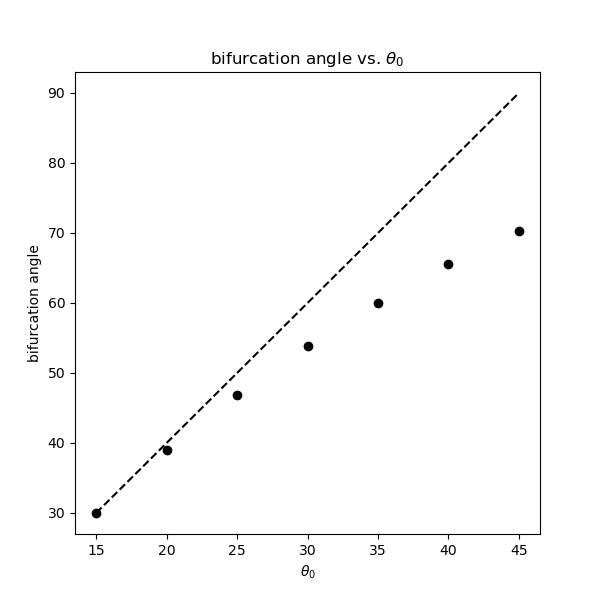

In [28]:
# plot bifurcation angle
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter([np.degrees(i[0]) for i in bif_angle], [i[1] for i in bif_angle], marker='o', color='black')
# (ang_thresh, np.degrees(ang_crit), yerr=np.degrees(std), fmt='o', capsize=3, color='black')
plt.xlabel(r'$\theta_0$')
plt.ylabel('bifurcation angle')
plt.title(r'bifurcation angle vs. $\theta_0$')
# add line x=theta_0 y=2theta_0
ax.plot([np.degrees(i[0]) for i in bif_angle], [2*np.degrees(i[0]) for i in bif_angle], color='black', linestyle='--')
plt.show()

In [31]:
import pickle

bifurcation = []

for i in range(15,50,5):
    with open(f'../bifurcation_traj/k50.0_t{i}_simpl.pkl', 'rb') as f:
        params_ksmall, res_ksmall = pickle.load(f)
        
    x_limit = i # check if reasonable
    y_threshold_initial = 1.0
    y_threshold = 10.0

    upper_target_trajectories = []
    lower_target_trajectories = []

    for r in res_ksmall:
        # Check if the trajectory goes straight at the beginning
        if np.all(np.abs(r.y[1][r.y[0] < x_limit]) < y_threshold_initial):
            # If it does, check if the trajectory reaches the upper target
            if r.y[1][-1] > y_threshold:
                upper_target_trajectories.append(r)
            # Check if the trajectory reaches the lower target
            elif r.y[1][-1] < -y_threshold:
                lower_target_trajectories.append(r)

    # Lists to store the y values for each group
    y_values_upper = []
    y_values_lower = []

    # Collect y values for the upper group
    for r in upper_target_trajectories:
        y_values_upper.append(r.y[1][:790])

    # Calculate average y values for the upper group
    avg_y_upper = np.mean(y_values_upper, axis=0)

    # Collect y values for the lower group
    for r in lower_target_trajectories:
        y_values_lower.append(r.y[1][:790])

    # Calculate average y values for the lower group
    avg_y_lower = np.mean(y_values_lower, axis=0)

    # Find the t value where the two averages intersect
    t_intersection = np.where(np.isclose(avg_y_upper, avg_y_lower, atol=0.1))[0]
    #select value greater than 1000
    t_intersection = t_intersection[t_intersection > 200]

   #print(f'Intersection at t = {t_intersection}')

    x_up_intersections = []
    x_low_intersections = []

    for r1 in upper_target_trajectories:
        for t in t_intersection:
            x_up_intersections.append(r1.y[0][t])
    
    for r2 in lower_target_trajectories:
        for t in t_intersection:
            x_low_intersections.append(r2.y[0][t])

    # concatenate x_up_intersections and x_low_intersections
    x_inters = np.concatenate((x_up_intersections, x_low_intersections))

    x_min = np.min(x_inters)
    x_max = np.max(x_inters)
    # print(f'x_inters: {x_inters}')
    # Calculate the average and std of the x values at the intersection
    x_intersection = np.mean(x_inters)
    x_intersection_std = np.std(x_inters)

    bifurcation.append([i, x_intersection, x_min, x_max, x_intersection_std])


In [32]:
params_ksmall

[50, 1, 0.7853981633974483, 78.78462024097664, 13.891854213354426]

In [33]:
# bifurcation
tar_x = params_ksmall[3]
tar_y = params_ksmall[4]

# convert bifurcatin x to angle
bifurcation_angle = []
for i in range(len(bifurcation)):
    bifurcation_angle.append([bifurcation[i][0],
                              np.degrees(np.arctan(tar_y/(tar_x-bifurcation[i][1]))),
                              abs(np.degrees(np.arctan(tar_y/(tar_x-bifurcation[i][1]))) - np.degrees(np.arctan(tar_y/(tar_x-bifurcation[i][2])))),
                              abs(np.degrees(np.arctan(tar_y/(tar_x-bifurcation[i][1]))) - np.degrees(np.arctan(tar_y/(tar_x-bifurcation[i][3])))),
                              np.degrees(bifurcation[i][4]/(tar_x))])

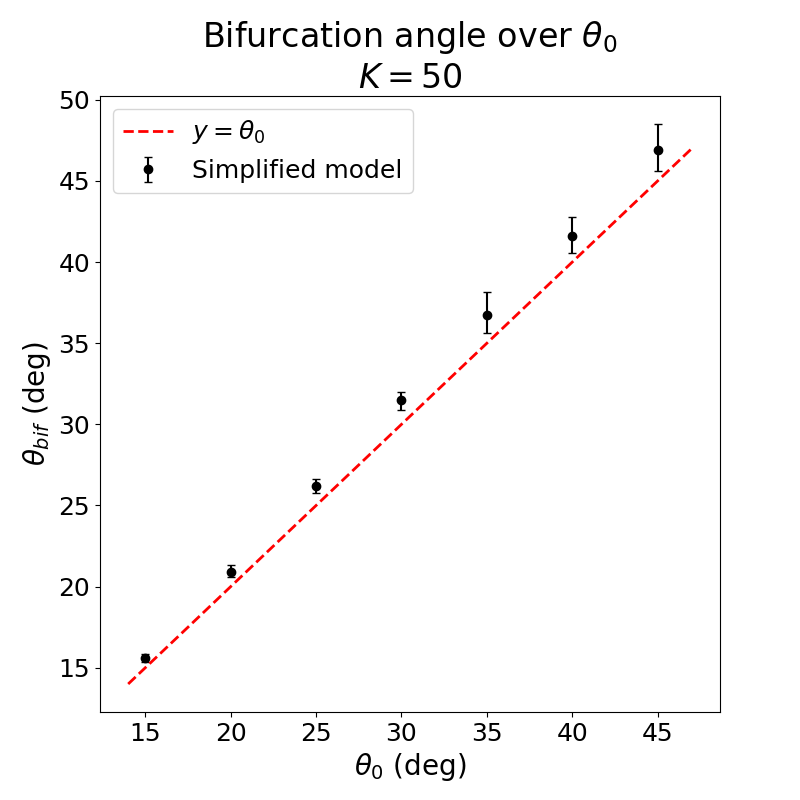

In [48]:
# plot bifurcation angle
fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar([i[0] for i in bifurcation_angle], [i[1] for i in bifurcation_angle], yerr=[[i[2] for i in bifurcation_angle],[i[3] for i in bifurcation_angle]], fmt='o', capsize=3, color='black', label='Simplified model')
# ax.scatter([np.degrees(i[0]) for i in bif_angle], [i[1] for i in bif_angle], marker='o', color='black', label='"mean field"')

plt.xlabel(r'$\theta_0$ (deg)', fontsize=20)
plt.ylabel(r'$\theta_{bif}$ (deg)', fontsize=20)
plt.title(r'Bifurcation angle over $\theta_0$'+'\n'+r'$K=50$', fontsize=24)

# plot line y=2x
ax.plot([14,47], [14,47], color='r', linestyle='--', lw='2',label=r'$y=\theta_0$')

# set tick size
ax.tick_params(axis='both', which='major', labelsize=18)

ax.legend(fontsize=18)
plt.savefig('../img/bifurcation_angle_over_theta0_k50.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [49]:
import pickle

bifurcation = []

for i in range(15,50,5):
    with open(f'../bifurcation_traj/k50.0_t{i}.pkl', 'rb') as f:
        params_ksmall, res_ksmall = pickle.load(f)
        
    x_limit = i # check if reasonable
    y_threshold_initial = 1.0
    y_threshold = 10.0

    upper_target_trajectories = []
    lower_target_trajectories = []

    for r in res_ksmall:
        # Check if the trajectory goes straight at the beginning
        if np.all(np.abs(r.y[1][r.y[0] < x_limit]) < y_threshold_initial):
            # If it does, check if the trajectory reaches the upper target
            if r.y[1][-1] > y_threshold:
                upper_target_trajectories.append(r)
            # Check if the trajectory reaches the lower target
            elif r.y[1][-1] < -y_threshold:
                lower_target_trajectories.append(r)

    # Lists to store the y values for each group
    y_values_upper = []
    y_values_lower = []

    # Collect y values for the upper group
    for r in upper_target_trajectories:
        y_values_upper.append(r.y[1][:790])

    # Calculate average y values for the upper group
    avg_y_upper = np.mean(y_values_upper, axis=0)

    # Collect y values for the lower group
    for r in lower_target_trajectories:
        y_values_lower.append(r.y[1][:790])

    # Calculate average y values for the lower group
    avg_y_lower = np.mean(y_values_lower, axis=0)

    # Find the t value where the two averages intersect
    t_intersection = np.where(np.isclose(avg_y_upper, avg_y_lower, atol=0.1))[0]
    #select value greater than 1000
    t_intersection = t_intersection[t_intersection > 200]

   #print(f'Intersection at t = {t_intersection}')

    x_up_intersections = []
    x_low_intersections = []

    for r1 in upper_target_trajectories:
        for t in t_intersection:
            x_up_intersections.append(r1.y[0][t])
    
    for r2 in lower_target_trajectories:
        for t in t_intersection:
            x_low_intersections.append(r2.y[0][t])

    # concatenate x_up_intersections and x_low_intersections
    x_inters = np.concatenate((x_up_intersections, x_low_intersections))

    x_min = np.min(x_inters)
    x_max = np.max(x_inters)
    # print(f'x_inters: {x_inters}')
    # Calculate the average and std of the x values at the intersection
    x_intersection = np.mean(x_inters)
    x_intersection_std = np.std(x_inters)

    bifurcation.append([i, x_intersection, x_min, x_max, x_intersection_std])


In [50]:
params_ksmall

[1000, 1000, 50, 1, 0.7853981633974483, 78.78462024097664, 13.891854213354426]

In [51]:
# bifurcation
tar_x = params_ksmall[3]
tar_y = params_ksmall[4]

# convert bifurcatin x to angle
bifurcation_angle = []
for i in range(len(bifurcation)):
    bifurcation_angle.append([bifurcation[i][0],
                              np.degrees(np.arctan(tar_y/(tar_x-bifurcation[i][1]))),
                              abs(np.degrees(np.arctan(tar_y/(tar_x-bifurcation[i][1]))) - np.degrees(np.arctan(tar_y/(tar_x-bifurcation[i][2])))),
                              abs(np.degrees(np.arctan(tar_y/(tar_x-bifurcation[i][1]))) - np.degrees(np.arctan(tar_y/(tar_x-bifurcation[i][3])))),
                              np.degrees(bifurcation[i][4]/(tar_x))])

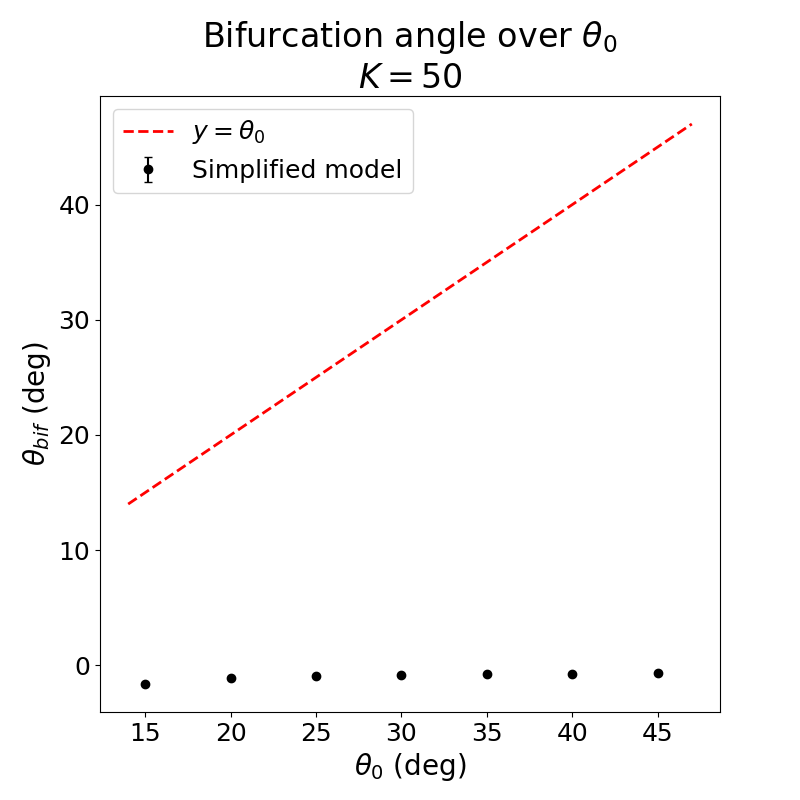

In [52]:
# plot bifurcation angle
fig, ax = plt.subplots(figsize=(8,8))
ax.errorbar([i[0] for i in bifurcation_angle], [i[1] for i in bifurcation_angle], yerr=[[i[2] for i in bifurcation_angle],[i[3] for i in bifurcation_angle]], fmt='o', capsize=3, color='black', label='Simplified model')
# ax.scatter([np.degrees(i[0]) for i in bif_angle], [i[1] for i in bif_angle], marker='o', color='black', label='"mean field"')

plt.xlabel(r'$\theta_0$ (deg)', fontsize=20)
plt.ylabel(r'$\theta_{bif}$ (deg)', fontsize=20)
plt.title(r'Bifurcation angle over $\theta_0$'+'\n'+r'$K=50$', fontsize=24)

# plot line y=2x
ax.plot([14,47], [14,47], color='r', linestyle='--', lw='2',label=r'$y=\theta_0$')

# set tick size
ax.tick_params(axis='both', which='major', labelsize=18)

ax.legend(fontsize=18)
# plt.savefig('../img/bifurcation_angle_over_theta0_k50.pdf', dpi=300, bbox_inches='tight')
plt.show()